In [1]:
%matplotlib inline
import sys
sys.path.append('sample4Acause/')
from forwardmodels import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm, multivariate_normal

### General idea:
Assume that we have some density estimator $K(e)$ using observed data $E^\ast$

Sample random $c^t$, set $t=1$ and run the loop:
1. Evaluate $e^t$ = $RTM(c^t)$
2. Estimate density $p_{e^t} = K(e^t)$
3. Sample new $c^t$ using $p_{e^t}$ and set $t = t + 1$

### True underlying distribution over causes (which we will not have access to in a real experiment)

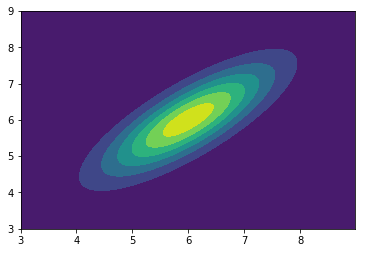

In [2]:
c1, c2 = np.mgrid[3:9:.01, 3:9:.01]; pos = np.dstack((c1, c2))
rv = multivariate_normal([6, 6], [[1.0, 0.8], [0.8, 1.0]])
fig2 = plt.figure(); ac2 = fig2.add_subplot(111)
ac2.contourf(c1, c2, rv.pdf(pos))

### Forward model (calling it prosail)

In [82]:
def PROSAIL(x):
    return(np.square(x)+2*np.tanh(x))
    #return(np.sin(x))

Text(0.5,1,'C* transformed to E* (observed)')

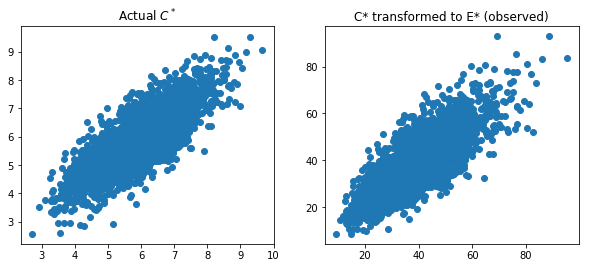

In [83]:
fig,ax = plt.subplots(1,2,figsize=[10,4])
C_true = rv.rvs(3000); E_true = PROSAIL(C_true)
ax[0].scatter(C_true[:,0],C_true[:,1]); ax[0].set_title('Actual $C^*$')
ax[1].scatter(E_true[:,0],E_true[:,1]); ax[1].set_title('C* transformed to E* (observed)')

###  KDE of $E^*$

In [84]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian').fit(E_true)

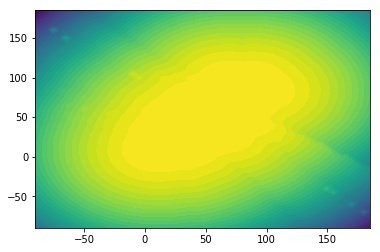

In [85]:
mini = -90; maks = 190; deli = 5; grid = int((maks-mini)/deli)
e1, e2 = np.mgrid[mini:maks:deli, mini:maks:deli]; pos = np.dstack((e1, e2))
plt.contourf(e1, e2, kde.score_samples(pos.reshape(grid**2,2)).reshape(grid,grid),40)

### ABC rejection sampling based on L2-norm as (dis)similarity measure
 $ $
 
FOR  $\,$ $n = 1... M$:
- sample $c \sim \pi$
- compute $e = PROSAIL(c)$
- compute distance $d$ between $e$ and $E^\ast$. Here it is the average of the 10 smallest L2-distances
- Accept $c$ as a sample from the underlying $P(c)$ if $d < \epsilon$

$ $

Notes: I am choosing a uniform prior because in hte real problem I wont have an idea of how the $c$ are distributed. Also, one has to find a good epsilon or save all the points and just choose the top 10$\%$

In [86]:
'''ABC rejection sampling'''
M = 5000
k = 10
order = 2
ABCsamples = []
for i in range(M):
    epsilon = 3#0.05
    c_ = np.random.uniform(low = 1, high = 10, size=(1,2))
    #epsilon = epsilon + epsilon*np.exp(np.abs(np.linalg.norm(c_))) # growing epsilon with scale
    e_ = PROSAIL(c_)
    dists = np.linalg.norm(E_true-e_,ord=order,axis=1)
    smallest = np.argpartition(dists,k)[:k]
    dist = np.mean( dists[smallest] )
    if dist <= epsilon:
        ABCsamples.append(c_)
ABCsamples = np.array(ABCsamples).reshape(-1,2)

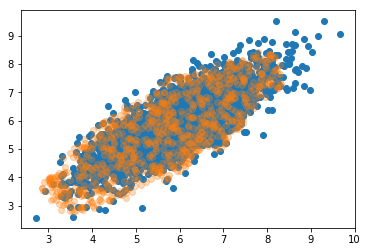

In [87]:
plt.scatter(C_true[:,0],C_true[:,1])
plt.scatter(ABCsamples[:,0],ABCsamples[:,1],alpha=0.3)

### ABC rejection sampling based on KDE as (dis)similarity measure

 $ $
 
FOR  $\,$ $n = 1... M$:
- sample $c \sim \pi$
- compute $e = PROSAIL(c)$
- compute $p_e = KDE(e)$
- Draw $u \sim U[0,1]$ and accept $c$ if $p_e > u$

$ $

Notes: It follows $C^*$ better. $p_e$ is not normalized and so I have to multiply with a high number hehe.

In [94]:
'''ABC rejection sampling /w KDE'''
M = 5000
k = 10
order = 2
ABCsamples = []
epsilon = 100000
for i in range(M):
    c_ = np.random.uniform(low = 1, high = 10, size=(1,2))
    e_ = PROSAIL(c_)
    pe = np.exp(kde.score(e_))
#    print(pe)
    if np.random.uniform() <= pe*epsilon:
        ABCsamples.append(c_)
ABCsamples = np.array(ABCsamples).reshape(-1,2)

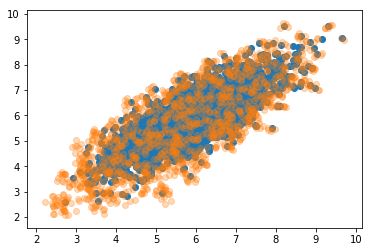

In [95]:
plt.scatter(C_true[:,0],C_true[:,1])
plt.scatter(ABCsamples[:,0],ABCsamples[:,1],alpha=0.3)

### Perturb samples with white noise, and accept a proportion of the jump based KDE

 $ $

Sample a bunch (N) of causes from a uniform: $C \sim U[min,max]$

FOR  $\,$ $t = 1... T$:
- Perturb all of the points $C_{new} = C_{old} + \gamma, \,\, \gamma \sim \mathcal{N}(0,\sigma I)$
- Compute the corresponding N effects $E = PROSAIL(C_{new})$
- Compute their N values of the estimated density function $p_E = KDE(E)$, $\,$ i.e. $p_E$ is a vector with N values
- Accept the a part of the pertubation $\gamma$ from  $C_{old} \rightarrow C_{new}$ by multiplying $p_E \otimes \gamma$ before perturbing.

$ $

Notes: All points creep towards the center. Again $p_e$ is not normalized, so what I actually do is divide $p_E$ with its max value to make it a vector with values in range [0,1]

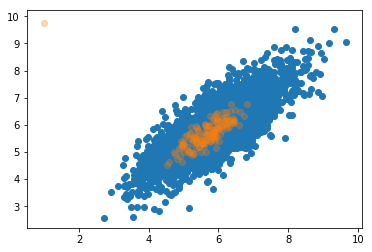

In [98]:
'''Moving Mercadona sampling /w KDE''' 
N = 150
T = 300
C_ = np.random.uniform(low = 1, high = 10, size=(N,2))

for t in range(T):
    pertubator = np.random.normal(loc=0.,scale=2,size=[N,2])
    C_hold = C_
    C_ = C_ + pertubator
    E_ = PROSAIL(C_)
    pe = np.exp(kde.score_samples(E_))
    C_ = C_hold + pertubator * (pe.reshape(N,1)/pe.max()) 
    
plt.scatter(C_true[:,0],C_true[:,1])
plt.scatter(C_[:,0],C_[:,1],alpha=0.3)

# Conclusion: Just makes all the points converge to the center

### Perturb all points with noise, asses the importance at each iteration of all point using KDE, make a new dataset by sampling with weights from the old with replacement


 $ $

Sample a bunch (N) of causes from a uniform: $C \sim U[min,max]$

FOR  $\,$ $t = 1... 3?$:  (converges superfast)
- Perturb all of the points $C_{new} = C_{old} + \gamma, \,\, \gamma \sim \mathcal{N}(0,\sigma I)$
- Compute the corresponding N effects $E = PROSAIL(C_{new})$
- Compute their N values of the estimated density function $p_E = KDE(E)$, $\,$ i.e. $p_E$ is a vector with N values
- Weighted sample with replacement from old $C$ to generate new $C$

$ $

Notes: Again I actually divide $p_E$ with its max value to make it a vector with values in range [0,1]

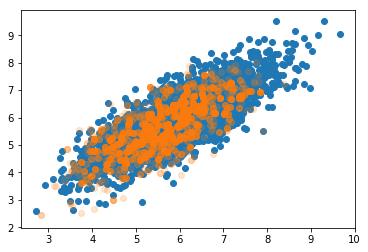

In [105]:
'''Moving Maradona sampling /w KDE''' # Pertubate samples w/ white noise,
N = 3000
T = 5
C_ = np.random.uniform(low = 1, high = 10, size=(N,2))

for t in range(T):
    pertubator = np.random.normal(loc=0.,scale=2,size=[N,2])
    C_ = C_ + pertubator
    C_hold = C_
    E_ = PROSAIL(C_)
    pe = np.exp(kde.score_samples(E_));
    ptot = np.sum(pe)
    for n in range(N):
        pick = np.random.choice(N,size=1,p=pe/ptot)[0]
        C_[n,:] = C_hold[pick,:] 

plt.scatter(C_true[:,0],C_true[:,1])
plt.scatter(C_[:,0],C_[:,1],alpha=0.2)

# Conclusion: Pretty nice importance weighted density estimate

## Visulatization in the c-domain of just exactly how helpful the KDE is to us:

In [127]:
C_ = np.random.uniform(low = 3, high = 9, size=(10000,2))
E_ = PROSAIL(C_)
dens_kde = np.exp(kde.score_samples(E_))
dens_true = rv.pdf(C_)

### If we could only access the true p(c) then for any c we could evaluate the density $p_c$ and use well known sampling techniques to create samples from it. Just to visualize how that information looks, let's generate a ton of c's from a uniform and just evaluate the true p(c) which is a multivariate normal pdf.

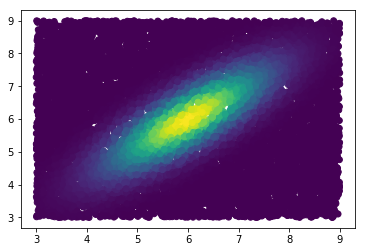

In [129]:
plt.scatter(C_[:,0],C_[:,1],c=dens_true)

### We cannot do that, but we do have access to a proxy of sorts for $p_c = p(c)$ which is $p_c^{proxy} = KDE(PROSAIL(c))$. As we can see below, it is a distorted version of $p_c$, but it has the right idea, and we have to find a way to make the most of it.

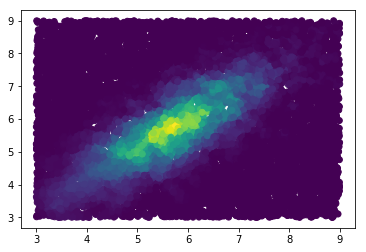

In [130]:
plt.scatter(C_[:,0],C_[:,1],c=dens_kde)